## Example 3 - `stripy` interpolation on the sphere

SSRFPACK is a Fortran 77 software package that constructs a smooth interpolatory or approximating surface to data values associated with arbitrarily distributed points on the surface of a sphere. It employs automatically selected tension factors to preserve shape properties of the data and avoid overshoot and undershoot associated with steep gradients.

The next three examples demonstrate the interface to SSRFPACK provided through `stripy`


#### Notebook contents

   - [Incommensurable meshes](#Define-two-different-meshes)
   - [Analytic function](#The-analytic-function-on-the-different-samplings)
   - [Interpolation](#Interpolation-from-coarse-to-fine)


The next example is [Ex4-Gradients](./Ex4-Gradients.ipynb)

---

### Define two different meshes

Create a fine and a coarse mesh without common points 

In [1]:
import stripy as stripy

cmesh = stripy.spherical_meshes.triangulated_cube_mesh(refinement_levels=3)
fmesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=True)

print cmesh.npoints
print fmesh.npoints

386
1922


In [2]:
help(cmesh.interpolate)

Help on method interpolate in module stripy.spherical:

interpolate(self, lons, lats, zdata, order=1) method of stripy.spherical_meshes.triangulated_cube_mesh instance
    Base class to handle nearest neighbour, linear, and cubic interpolation.
    Given a triangulation of a set of nodes on the unit sphere, along with data
    values at the nodes, this method interpolates (or extrapolates) the value
    at a given longitude and latitude.
    
    Parameters
    ----------
     lons : float / array of floats, shape (l,)
            longitudinal coordinate(s) on the sphere
     lats : float / array of floats, shape (l,)
            latitudinal coordinate(s) on the sphere
     zdata : array of floats, shape (n,)
            value at each point in the triangulation
            must be the same size of the mesh
     order : int (default=1)
            order of the interpolatory function used
             0 = nearest-neighbour
             1 = linear
             3 = cubic
    
    Returns
 

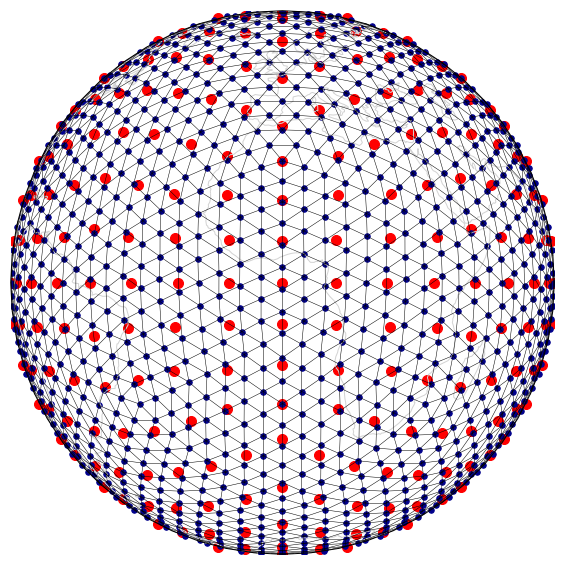

In [3]:
%matplotlib inline

import gdal
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np



def mesh_fig(mesh, meshR, name):

    fig = plt.figure(figsize=(10, 10), facecolor="none")
    ax  = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0, globe=None))
    ax.coastlines(color="lightgrey")
    ax.set_global()

    generator = mesh
    refined   = meshR

    lons0 = np.degrees(generator.lons)
    lats0 = np.degrees(generator.lats)

    lonsR = np.degrees(refined.lons)
    latsR = np.degrees(refined.lats)

    lst = generator.lst
    lptr = generator.lptr


    ax.scatter(lons0, lats0, color="Red",
                marker="o", s=100.0, transform=ccrs.Geodetic())

    ax.scatter(lonsR, latsR, color="DarkBlue",
                marker="o", s=30.0, transform=ccrs.Geodetic())

    segs = refined.identify_segments()

    for s1, s2 in segs:
        ax.plot( [lonsR[s1], lonsR[s2]],
                 [latsR[s1], latsR[s2]], 
                 linewidth=0.5, color="black", transform=ccrs.Geodetic())

    # fig.savefig(name, dpi=250, transparent=True)
    
    return

mesh_fig(cmesh,  fmesh, "Two grids" )



### Analytic function 

Define a relatively smooth function that we can interpolate from the coarse mesh to the fine mesh and analyse 

In [4]:

def analytic(lons, lats, k1, k2):
     return np.cos(k1*lons) * np.sin(k2*lats)

coarse_afn = analytic(cmesh.lons, cmesh.lats, 5.0, 2.0)
fine_afn   = analytic(fmesh.lons, fmesh.lats, 5.0, 2.0)


### The analytic function on the different samplings

It is helpful to be able to view a mesh in 3D to verify that it is an appropriate choice. Here, for example, is the icosahedron with additional points in the centroid of the faces.

This produces triangles with a narrow area distribution. In three dimensions it is easy to see the origin of the size variations.

In [13]:

import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[600,600], near=-10.0)

ctris = lv.triangles("ctriangulation",  wireframe=True, colour="#444444", opacity=0.8)
ctris.vertices(cmesh.points)
ctris.indices(cmesh.simplices)

ctris2 = lv.triangles("ctriangles",  wireframe=False, colour="#77ff88", opacity=1.0)
ctris2.vertices(cmesh.points)
ctris2.indices(cmesh.simplices)
ctris2.values(coarse_afn)
ctris2.colourmap("#990000 #FFFFFF #000099")


cnodes = lv.points("cnodes", pointsize=4.0, pointtype="shiny", colour="#448080", opacity=0.75)
cnodes.vertices(cmesh.points)


fnodes = lv.points("fnodes", pointsize=3.0, pointtype="shiny", colour="#448080", opacity=0.75)
fnodes.vertices(fmesh.points)

ftris2 = lv.triangles("ftriangulation",  wireframe=True, colour="#444444", opacity=0.8)
ftris2.vertices(fmesh.points)
ftris2.indices(fmesh.simplices)

ftris = lv.triangles("ftriangles",  wireframe=False, colour="#77ff88", opacity=1.0)
ftris.vertices(fmesh.points)
ftris.indices(fmesh.simplices)
ftris.values(fine_afn)
ftris.colourmap("#990000 #FFFFFF #000099")

# view the pole

lv.translation(0.0, 0.0, -3.0)
lv.rotation(-20, 0.0, 0.0)

lv.hide("fnodes")
lv.hide("ftriangulation")
lv.hide("ftriangules")



lv.control.Panel()
lv.control.Button(command="hide triangles; hide points; show cnodes; show ctriangles; show ctriangulation; redraw", label="Coarse")
lv.control.Button(command="hide triangles; hide points; show fnodes; show ftriangles; show ftriangulation; redraw", label="Fine")

lv.control.show()




<IPython.core.display.Javascript object>

In [11]:
lv.camera()

lv.translation(0.0, 0.0, -3.464)
lv.rotation(-37.354, 3.014, 1.069)


{'rotation': [-0.320340394973755,
  0.0219289250671864,
  0.0172597169876099,
  0.947],
 'translation': [0.0, 0.0, -3.464],
 'xyzrotation': [-37.354, 3.014, 1.069]}

### Interpolation from coarse to fine

The `interpolate` method of the sTriangulation takes arrays of longitude, latitude points (in radians) and an array of
data on the mesh vertices. It returns an array of interpolated values and a status array that states whether each value
represents an interpolation, extrapolation or neither (an error condition). The interpolation can be nearest-neighbour (order=0),
linear (order=1) or cubic spline (order=3).

In [6]:
interp_c2f1, err = cmesh.interpolate(fmesh.lons, fmesh.lats, order=1, zdata=coarse_afn)
interp_c2f3, err = cmesh.interpolate(fmesh.lons, fmesh.lats, order=3, zdata=coarse_afn)

err_c2f1 = interp_c2f1-fine_afn
err_c2f3 = interp_c2f3-fine_afn

In [14]:
import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

fnodes = lv.points("fnodes", pointsize=3.0, pointtype="shiny", colour="#448080", opacity=0.75)
fnodes.vertices(fmesh.points)

ftris = lv.triangles("ftriangles",  wireframe=False, colour="#77ff88", opacity=0.8)
ftris.vertices(fmesh.points)
ftris.indices(fmesh.simplices)
ftris.values(fine_afn, label="original")
ftris.values(interp_c2f1, label="interp1")
ftris.values(interp_c2f3, label="interp3")
ftris.values(err_c2f1, label="interperr1")
ftris.values(err_c2f3, label="interperr3")
ftris.colourmap("#990000 #FFFFFF #000099")


cb = ftris.colourbar()

# view the pole

lv.translation(0.0, 0.0, -3.0)
lv.rotation(-20, 0.0, 0.0)



lv.control.Panel()
lv.control.Range('specular', range=(0,1), step=0.1, value=0.4)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
ftris.control.List(["original", "interp1", "interp3", "interperr1", "interperr3"], property="colourby", value="orginal", command="redraw")
lv.control.show()

<IPython.core.display.Javascript object>

The next example is [Ex4-Gradients](./Ex4-Gradients.ipynb)